# Causal Discovery on SEASFIRE Dataset
Using PyBnesian, PC, and GES (CausalLearn)

In [1]:
# !pip install pybnesian causallearn pandas matplotlib networkx

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import seaborn as sns
from utils import *

In [3]:
data_path = "/home/emiliano/Documents/ISP/meditwin_workshop/causal-drought-fire/data/processed/dataframe_SeasFire_EDID_ET_8D_2001_2021.csv"
df = pd.read_csv(data_path)
df = df.loc[df.lccs_class_2>80]
df.shape[0]/1e6
selected_vars = ["drought_distance","drought_ecosystem","fwi_mean","ndvi","oci_nao","pop_dens","rel_hum","vpd","t2m_mean"]
data = df[selected_vars].dropna()
data.shape

(316983, 9)

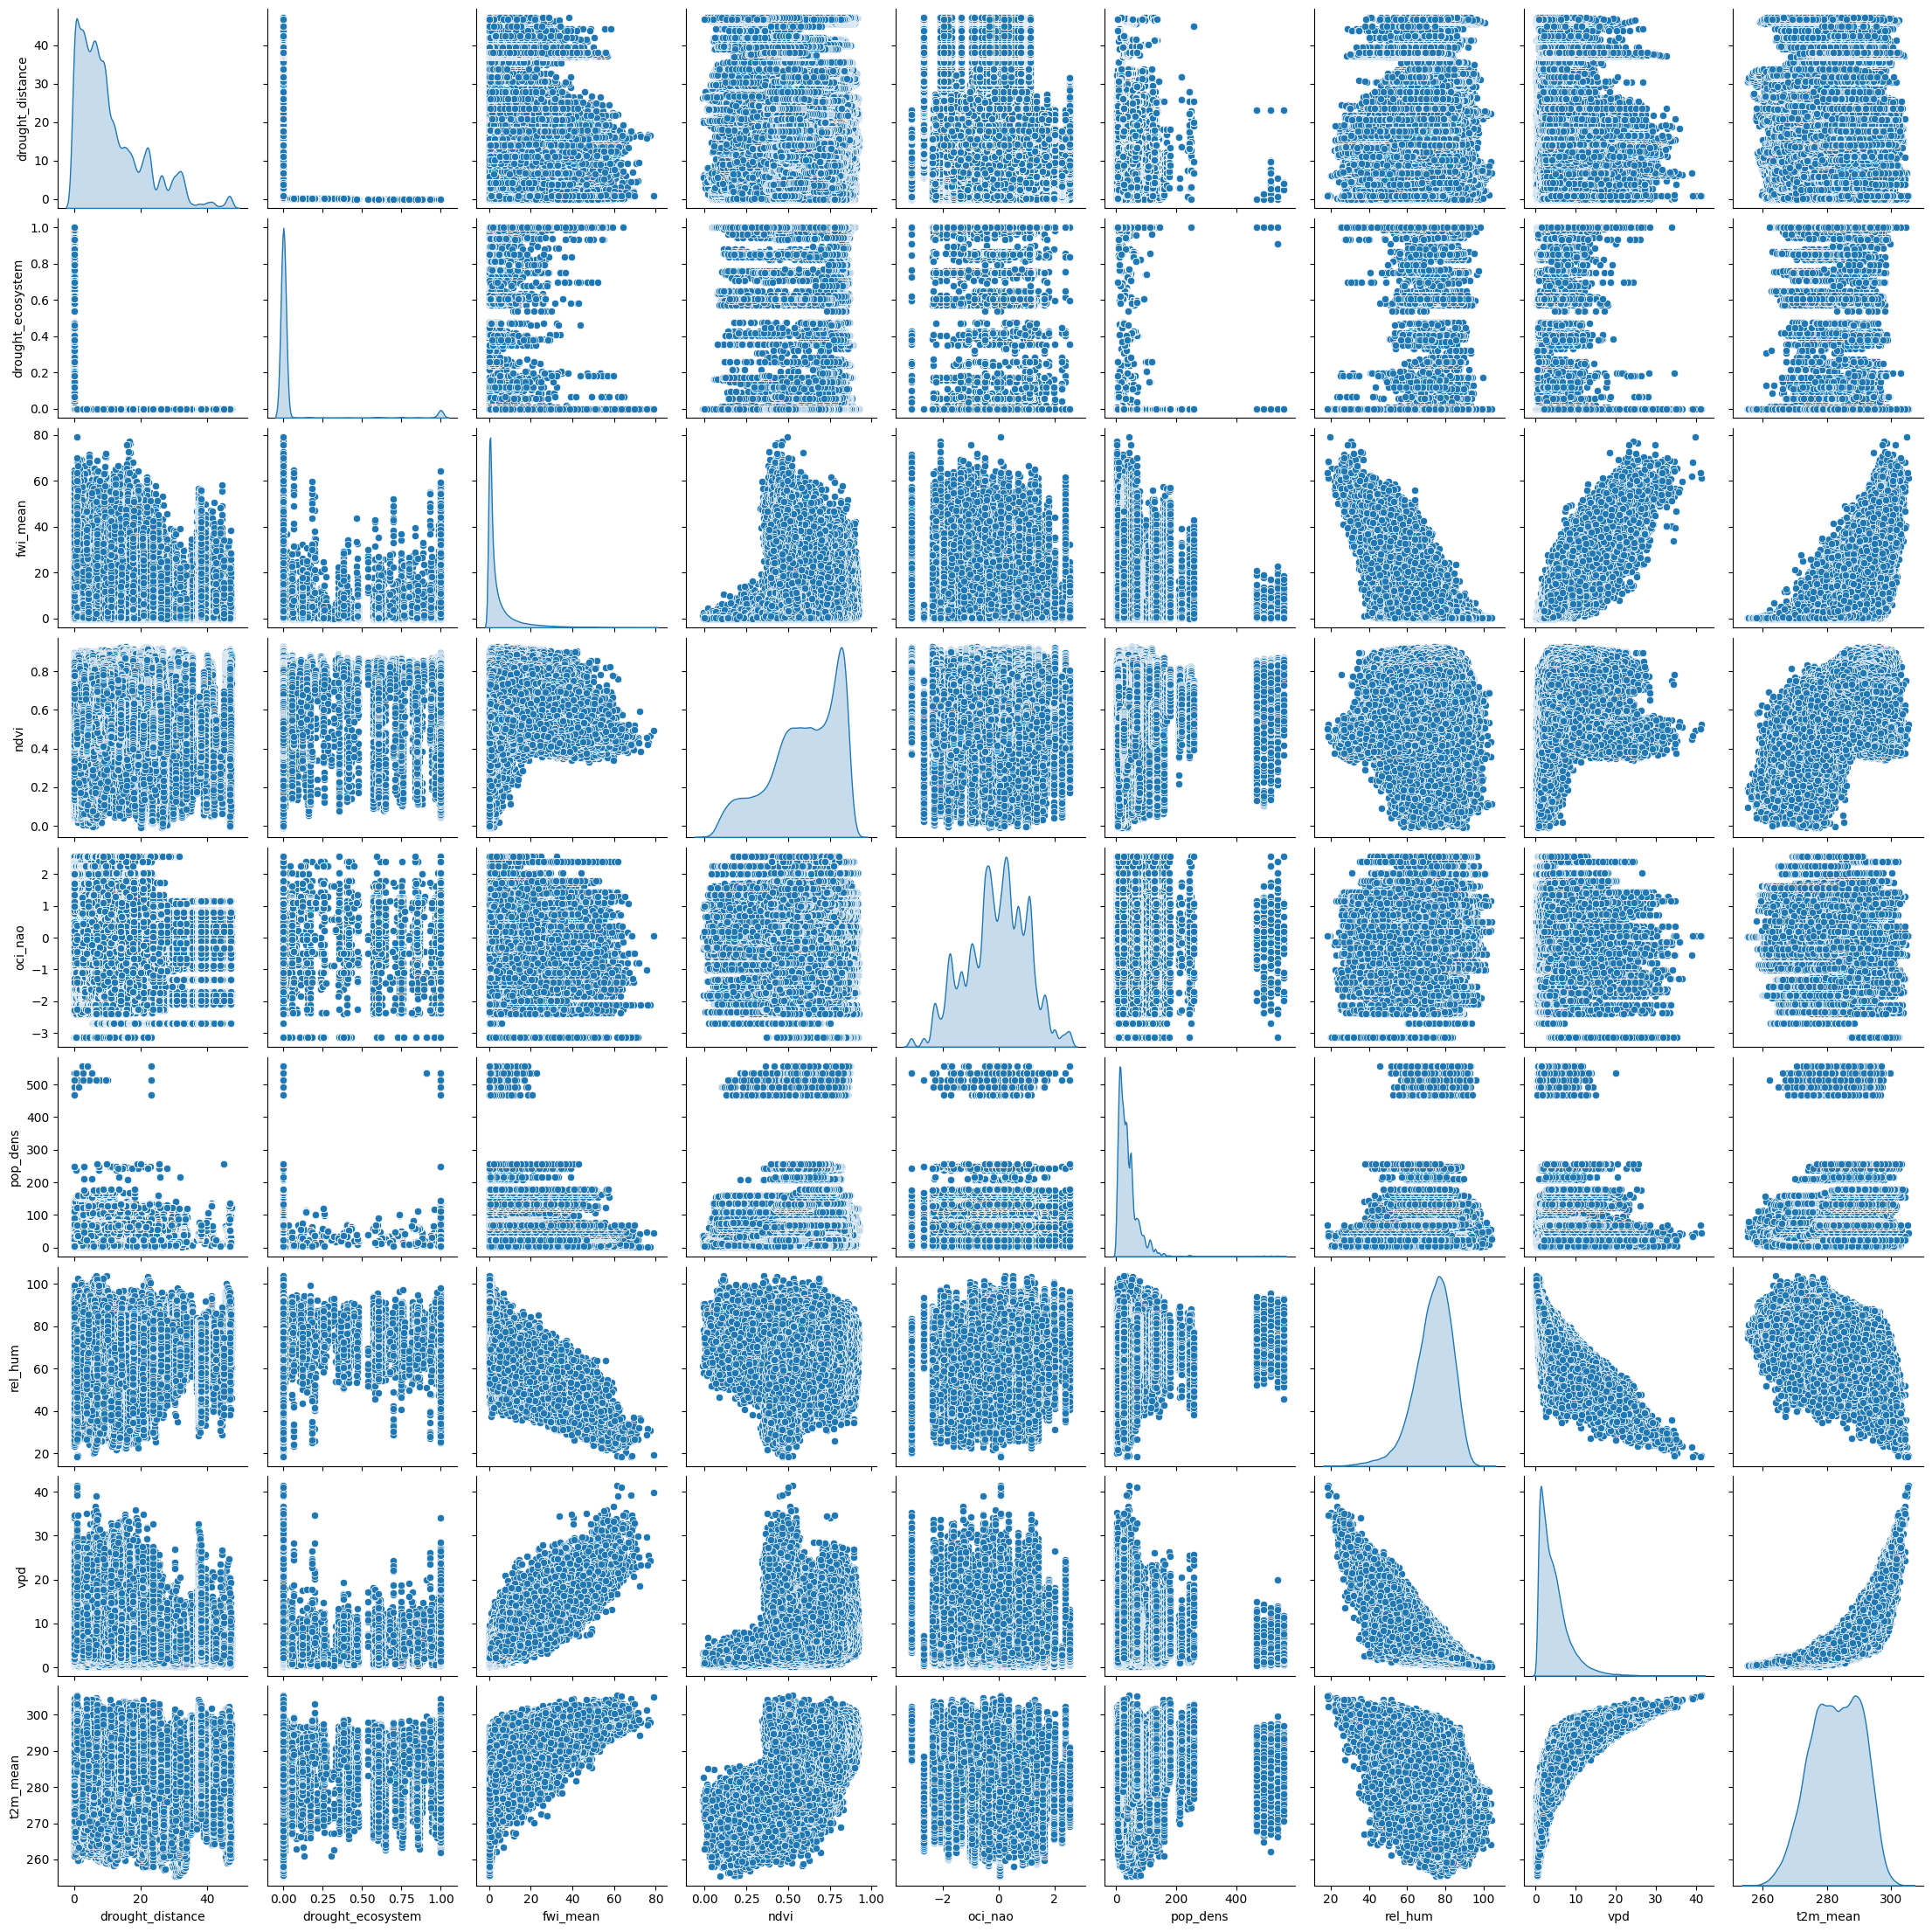

In [76]:
sns.pairplot(data, diag_kind="kde", height=2.5)

## 1. Structure Learning using PyBnesian

In [4]:
from pybnesian import hc, BIC, GaussianNetworkType, KDENetworkType
gn = GaussianNetworkType()
mod = hc(df=data, bn_type=gn , score="bic")

In [5]:
nodes = mod.nodes()

In [6]:
arcs = mod.arcs()
edges = []

In [7]:
adjacency_matrix = get_adjacency_matrix(arcs, edges, nodes)
adjacency_matrix

drought_distance  drought_ecosystem  fwi_mean  ndvi  \
drought_distance                  0                  0         1     1   
drought_ecosystem                 1                  0         1     1   
fwi_mean                          0                  0         0     0   
ndvi                              0                  0         1     0   
oci_nao                           0                  0         1     0   
pop_dens                          0                  0         1     0   
rel_hum                           0                  0         1     0   
vpd                               0                  0         1     0   
t2m_mean                          0                  0         1     0   

                   oci_nao  pop_dens  rel_hum  vpd  t2m_mean  
drought_distance         1         1        1    0         1  
drought_ecosystem        1         1        1    1         1  
fwi_mean                 0         0        0    0         0  
ndvi                     1         1        1    1         1  
oci_nao                  0         0        1    0         0  
pop_dens                 0         0        0    0         0  
rel_hum                  0         1        0    0         0  
vpd                      1         0        1    0         1  
t2m_mean                 1         1        1    0         0

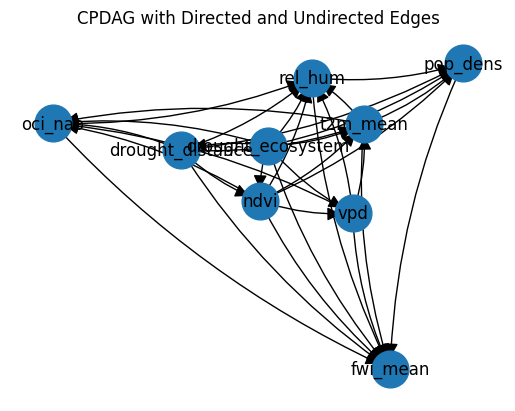

In [8]:
draw_cpdag(arcs, edges, nodes, arrowsize=20)

In [9]:
#kde = KDENetworkType()
#mod = hc(df=data, bn_type=kde )

In [12]:
import time
def run_nonlinearGES(data, num_samples):
    print("num samples: ", num_samples)
    t0 = time.time()
    kde = KDENetworkType()

    # the data goes into the inependence test object which is weird
    dat = data.sample(num_samples)
    mod = hc(df=dat, bn_type=kde )
    t1 = time.time()
    print("Time taken: ", t1-t0)
    return {"cpdag":mod, "time":t1-t0}


In [13]:
n = 250
res = run_nonlinearGES(data, n)

num samples:  250
Time taken:  2.725548505783081


In [20]:
ns = [100, 150, 250, 500, 1000, 2500, 5000, 10000]
res = [run_nonlinearGES(data, n) for n in ns]

num samples:  100
Time taken:  0.649362325668335
num samples:  150
Time taken:  0.5002334117889404
num samples:  250
Time taken:  1.5774428844451904
num samples:  500
Time taken:  2.2777810096740723
num samples:  1000
Time taken:  5.6892359256744385
num samples:  2500
Time taken:  11.198486804962158
num samples:  5000
Time taken:  28.969393968582153
num samples:  10000
Time taken:  69.26488518714905


In [21]:
ts = [r["time"] for r in res]

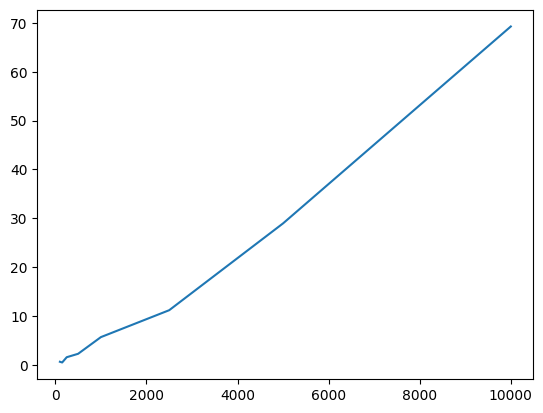

In [22]:
plt.plot(ns, ts)

In [23]:
g = res[-1]["cpdag"]  

In [24]:
# get the adjacency matrix from edge and arc list
arcs = g.arcs()
edges = []#g.edges()
nodes = g.nodes()


In [25]:
adjacency_matrix = get_adjacency_matrix(arcs, edges, nodes)
adjacency_matrix

drought_distance  drought_ecosystem  fwi_mean  ndvi  \
drought_distance                  0                  0         0     1   
drought_ecosystem                 1                  0         0     0   
fwi_mean                          0                  0         0     0   
ndvi                              0                  0         0     0   
oci_nao                           0                  0         0     0   
pop_dens                          0                  0         0     0   
rel_hum                           0                  0         0     1   
vpd                               0                  0         0     0   
t2m_mean                          0                  0         0     1   

                   oci_nao  pop_dens  rel_hum  vpd  t2m_mean  
drought_distance         1         1        0    0         0  
drought_ecosystem        0         0        0    0         0  
fwi_mean                 0         0        0    1         1  
ndvi                     1         0        0    0         0  
oci_nao                  0         0        0    0         0  
pop_dens                 0         0        0    0         0  
rel_hum                  0         0        0    0         1  
vpd                      0         0        1    0         1  
t2m_mean                 1         0        0    0         0

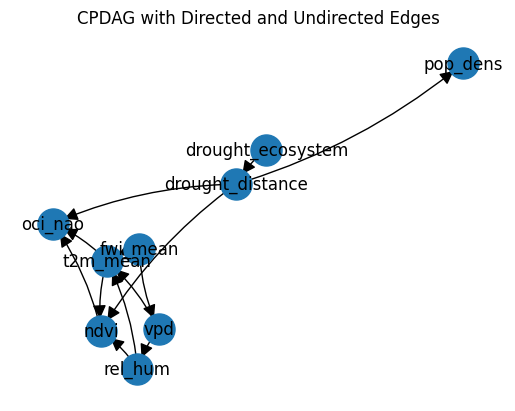

In [27]:
draw_cpdag(arcs, edges, nodes, node_size=500, arrowsize=20)

In [43]:
data.to_numpy().shape

(316983, 9)

## 2. Score-Based Learning using GES (CausalLearn)

In [56]:
from causallearn.search.ScoreBased.GES import ges


# or customized parameters
mod = ges(data, score_func="local_score_BIC")




In [57]:
data.shape[0]**2

100478222289

In [58]:
adj_mat = mod["G"].graph
nodes = list(data.columns)

adj_mat

array([[ 0, -1,  0,  1,  1,  1,  0,  1,  1],
       [ 1,  0,  1,  0,  1,  1,  0,  1,  0],
       [ 0, -1,  0, -1,  0,  1, -1, -1,  1],
       [-1,  0, -1,  0, -1,  1, -1, -1,  1],
       [-1, -1,  0,  1,  0,  0,  1, -1,  1],
       [-1, -1, -1, -1,  0,  0, -1,  0,  0],
       [ 0,  0, -1, -1, -1,  1,  0, -1,  1],
       [-1, -1,  1,  1,  1,  0,  1,  0,  1],
       [-1,  0, -1, -1, -1,  0, -1, -1,  0]])

In [59]:
from itertools import combinations, permutations, product

def adjMat_causLearn2pybnesian(adj_mat, nodes):
    node_idx = np.arange(len(nodes), dtype=int)
    combo_list = list(combinations(node_idx,2))
    arcs = []
    edges = []
    for combo in combo_list:
        if (adj_mat[combo[0], combo[1]] == -1) & (adj_mat[combo[1], combo[0]] == 1):
            arcs.append(combo)
        if (adj_mat[combo[0], combo[1]] == 1) & (adj_mat[combo[1], combo[0]] == -1):
            arcs.append((combo[1], combo[0]))
        elif (adj_mat[combo[0], combo[1]] == 1) & (adj_mat[combo[0], combo[1]] == 1):   
            edges.append(combo)
        else:
            pass
    edges = [(nodes[e[0]],nodes[e[1]]) for e in edges]
    arcs = [(nodes[a[0]],nodes[a[1]]) for a in arcs]
    return edges, arcs
    

In [60]:
edges, arcs = adjMat_causLearn2pybnesian(adj_mat, nodes)

In [61]:
adjacency_matrix = get_adjacency_matrix(arcs, edges, nodes)
adjacency_matrix

drought_distance  drought_ecosystem  fwi_mean  ndvi  \
drought_distance                  0                  1         0     0   
drought_ecosystem                 0                  0         0     0   
fwi_mean                          0                  1         0     0   
ndvi                              1                  0         0     0   
oci_nao                           1                  1         0     0   
pop_dens                          1                  1         1     1   
rel_hum                           0                  0         0     0   
vpd                               1                  1         0     0   
t2m_mean                          1                  0         1     1   

                   oci_nao  pop_dens  rel_hum  vpd  t2m_mean  
drought_distance         0         0        0    0         0  
drought_ecosystem        0         0        0    0         0  
fwi_mean                 0         0        0    1         0  
ndvi                     1         0        0    1         0  
oci_nao                  0         0        0    1         0  
pop_dens                 0         0        1    0         0  
rel_hum                  1         0        0    1         0  
vpd                      0         0        0    0         0  
t2m_mean                 1         0        1    1         0

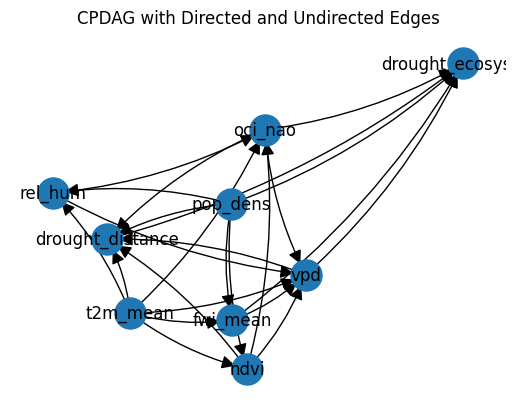

In [62]:
draw_cpdag(arcs, edges, nodes, node_size=500, arrowsize=20)

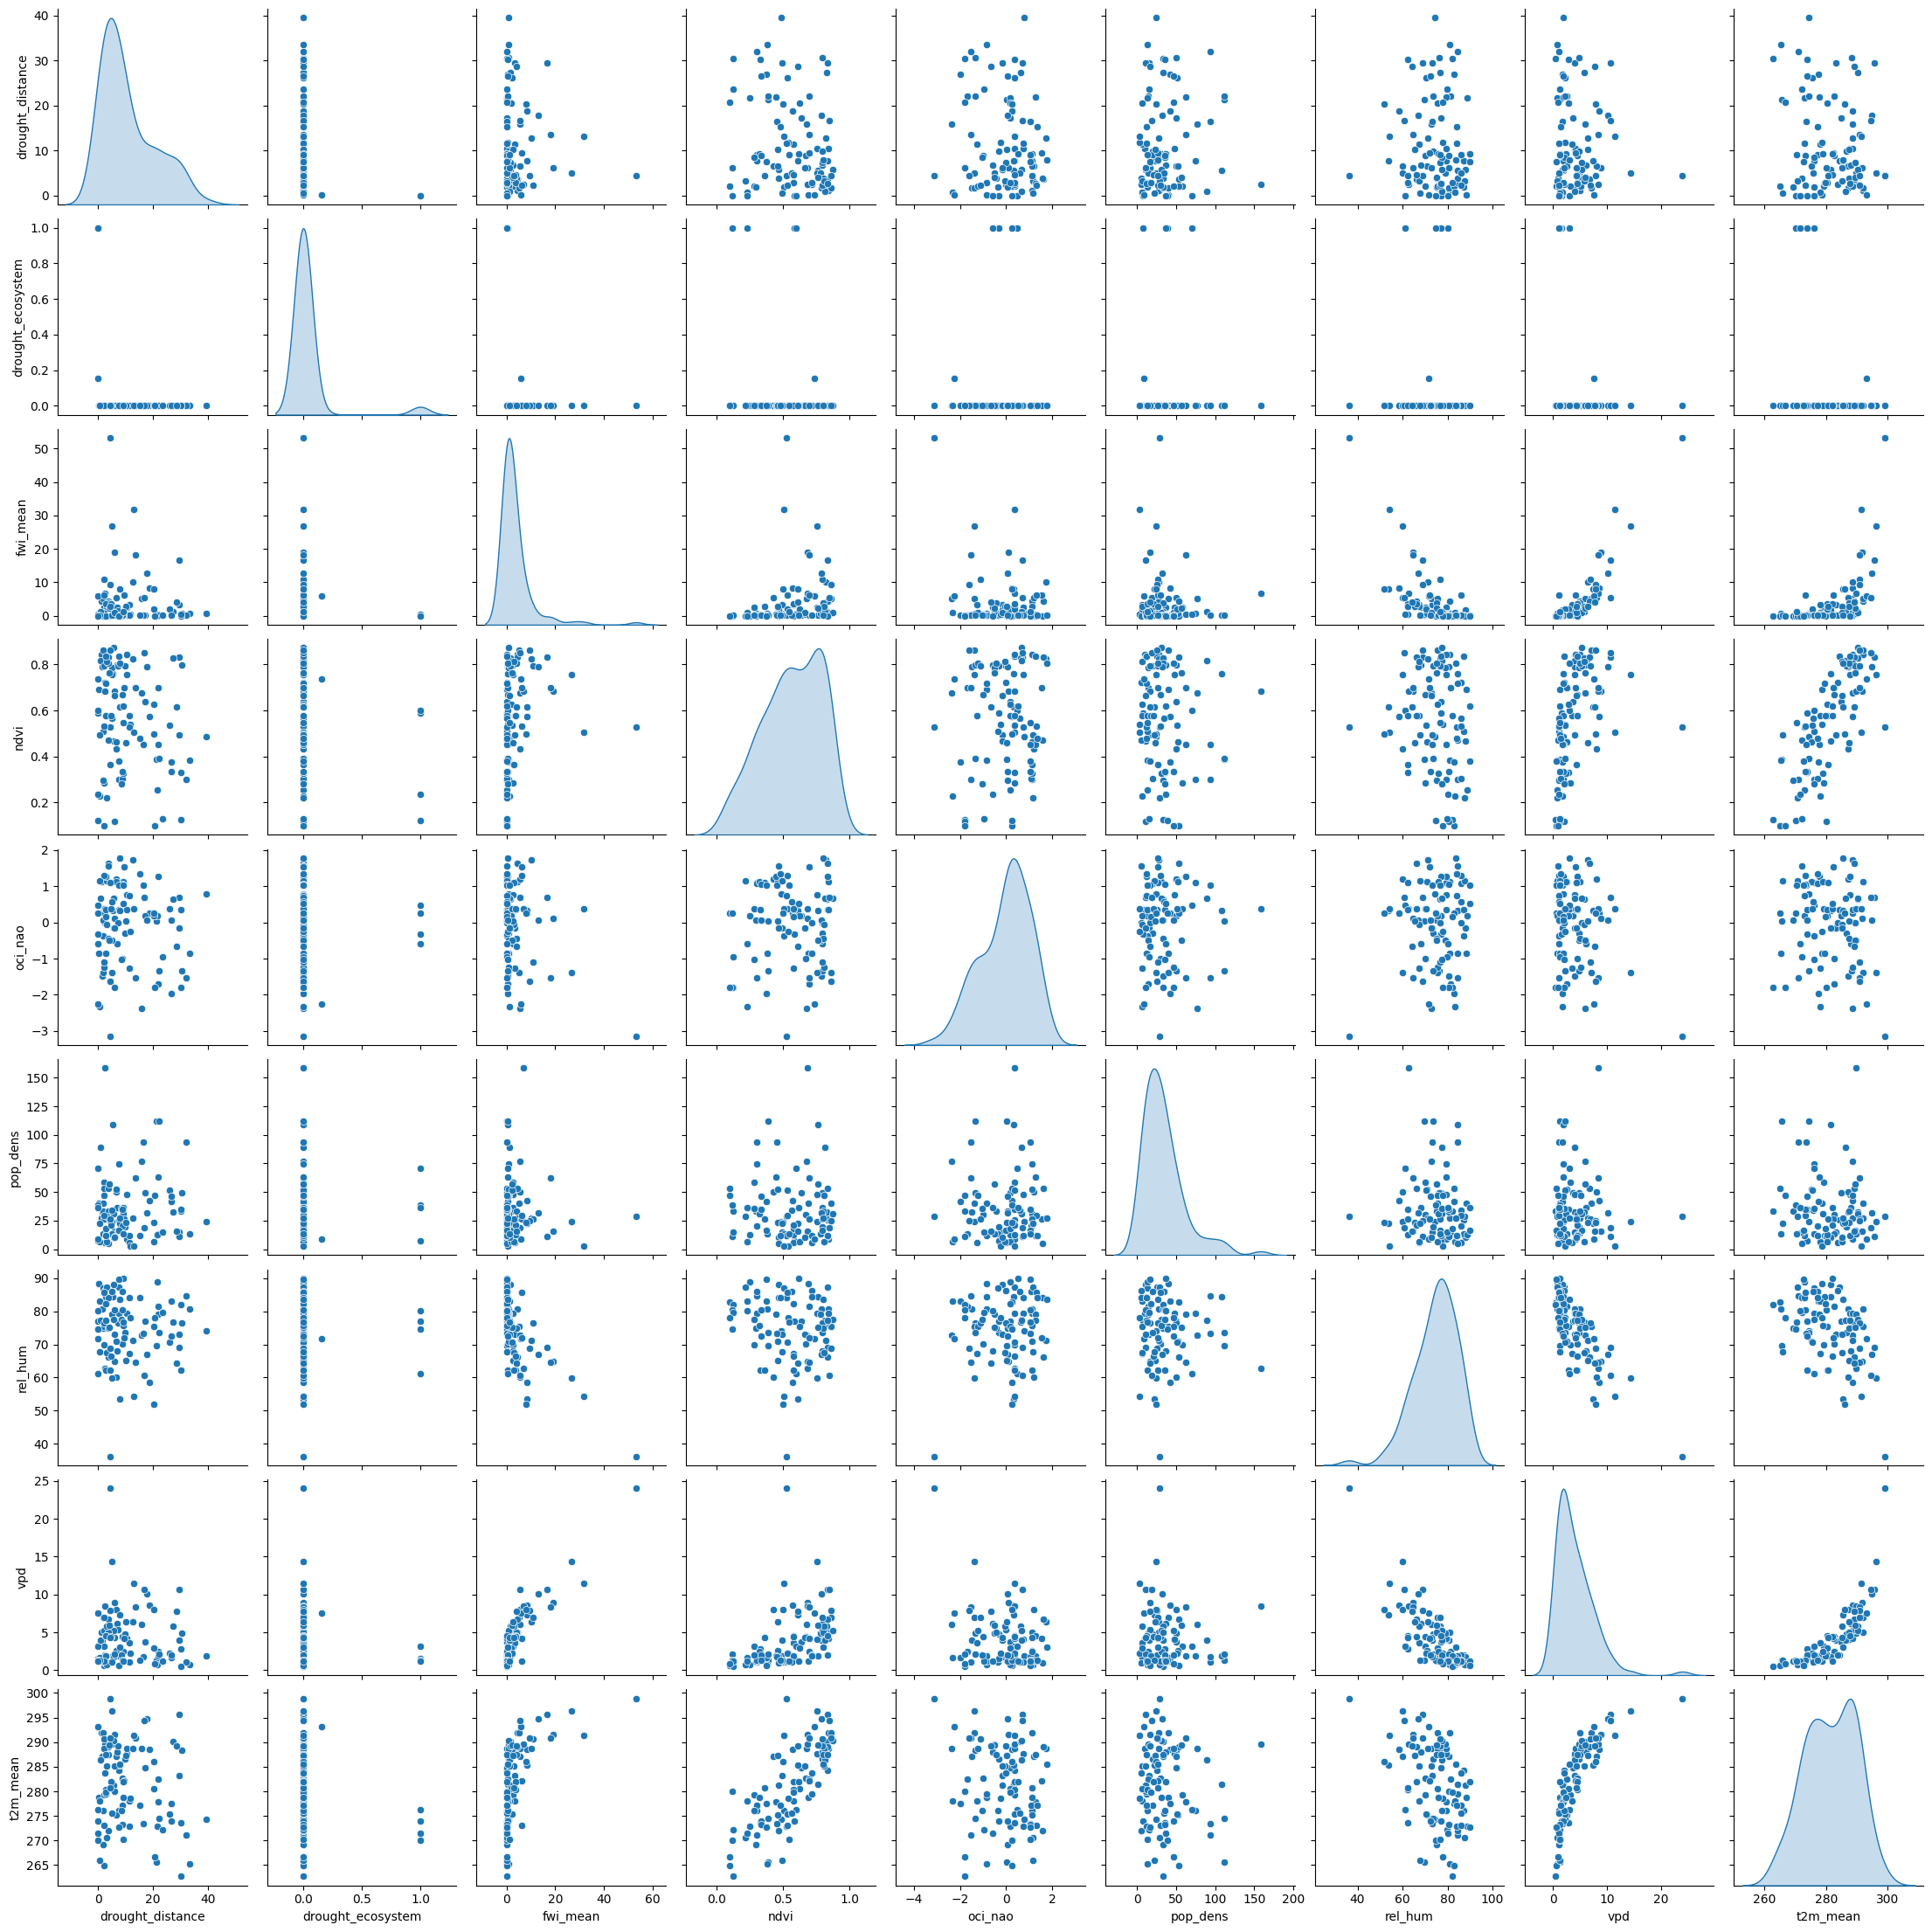

In [77]:
n = 100
dat = data.sample(n)
sns.pairplot(dat, diag_kind="kde", height=2.5)

In [78]:
mod = ges(dat.to_numpy(), score_func="local_score_marginal_general")

/home/emiliano/anaconda3/envs/1_PC/lib/python3.11/site-packages/causallearn/utils/ScoreUtils.py:574: RuntimeWarning: overflow encountered in exp
  s2 = np.exp(2 * logtheta)[0]  # noise variance
/home/emiliano/anaconda3/envs/1_PC/lib/python3.11/site-packages/causallearn/utils/ScoreUtils.py:579: RuntimeWarning: invalid value encountered in multiply
  A = s2 * np.eye(x.shape[0])
/home/emiliano/anaconda3/envs/1_PC/lib/python3.11/site-packages/causallearn/utils/ScoreUtils.py:584: RuntimeWarning: invalid value encountered in multiply
  A = 2 * s2 * np.eye(x.shape[0])
/home/emiliano/anaconda3/envs/1_PC/lib/python3.11/site-packages/causallearn/utils/ScoreUtils.py:110: ComplexWarning: Casting complex values to real discards the imaginary part
  return evals.astype(float), evec.astype(float)


ValueError: operands could not be broadcast together with shapes (2,2) (2,100) 

In [ ]:
adj_mat = mod["G"].graph
adj_mat

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
edges, arcs = adjMat_causLearn2pybnesian(adj_mat, nodes)

In [ ]:
adjacency_matrix = get_adjacency_matrix(arcs, edges, nodes)
adjacency_matrix

drought_distance  drought_ecosystem  fwi_mean  ndvi  \
drought_distance                  0                  0         0     0   
drought_ecosystem                 0                  0         0     0   
fwi_mean                          0                  0         0     0   
ndvi                              0                  0         0     0   
oci_nao                           0                  0         0     0   
pop_dens                          0                  0         0     0   
rel_hum                           0                  0         0     0   
vpd                               0                  0         0     0   
t2m_mean                          0                  0         0     0   

                   oci_nao  pop_dens  rel_hum  vpd  t2m_mean  
drought_distance         0         0        0    0         0  
drought_ecosystem        0         0        0    0         0  
fwi_mean                 0         0        0    0         0  
ndvi                     0         0        0    0         0  
oci_nao                  0         0        0    0         0  
pop_dens                 0         0        0    0         0  
rel_hum                  0         0        0    0         0  
vpd                      0         0        0    0         0  
t2m_mean                 0         0        0    0         0

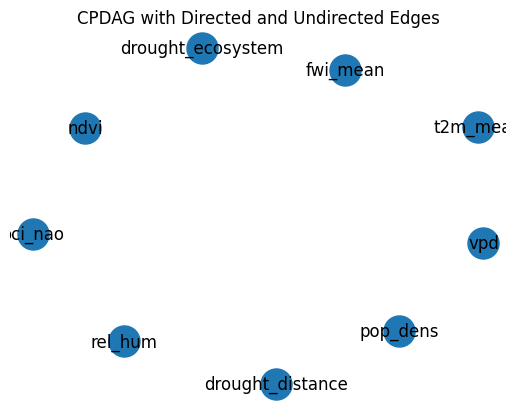

In [ ]:
draw_cpdag(arcs, edges, nodes, node_size=500, arrowsize=20)